In [29]:
# Para visualización en notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)
import os

# Números y Datos
import numpy as np
import pandas as pd

import networkx as nx

from glob import glob
from pathlib import Path

## Bajamos datos
### Primero datos de sujetos

In [30]:
# !wget -q https://www.dropbox.com/s/eei6gnw10o20mcn/DataSujetos.zip?dl=1 -O DataSujetos.zip
# !unzip -q DataSujetos
# !wget -O aal_extended_withCoords.csv https://www.dropbox.com/scl/fi/pu1qdch4c3khk0uol9l0w/aal_extended_withCoords.csv?rlkey=bsnfot3b9ycp7slble59e1cws&dl=1


## Luego atlas
### Son 116 regiones cerebrales
La columna "1" indica el nombre de la subregión, la columna "3" indica a qué región cerebral pertenece, la columna "4" en qué hemisferio se localiza (L=izquierda, R=derecham, --= está en la línea media), las columnas "5", "6" y "7" indican las coordenadas x, y, z de cada subregión

In [31]:
RegionsNames = pd.read_csv("aal_extended_withCoords.csv", header=None).iloc[:,1:]
RegionsNames

1     2          3   4   5   6   7
0         Precentral_L  2001    Central   L -39  -6  51
1         Precentral_R  2002    Central   R  41  -8  52
2        Frontal_Sup_L  2101    Frontal   L -18  35  42
3        Frontal_Sup_R  2102    Frontal   R  22  31  44
4    Frontal_Sup_Orb_L  2111    Frontal   L -17  47 -13
..                 ...   ...        ...  ..  ..  ..  ..
111           Vermis_6  9130  Cerebelum  --   2 -67 -15
112           Vermis_7  9140  Cerebelum  --   2 -72 -25
113           Vermis_8  9150  Cerebelum  --   2 -64 -34
114           Vermis_9  9160  Cerebelum  --   2 -55 -35
115          Vermis_10  9170  Cerebelum  --   1 -46 -32

[116 rows x 7 columns]

## Lista de archivos
Tenemos varios sujetos para 4 condiciones, una correspondiente a vigilia y 3 a diferentes estadios del sueño no REM (*rapid eye movement*):<br>

"W": despierto ("Wake")
<br> "N1": sueño "leve"
<br>"N2": sueño "intermedio"
<br>"N3": sueño "profundo"

# TP 2

## Tarea 1: Visualización

Para cada estadío del sueño (despierto -W - y N 1, N 2, N 3) calcular el promedio entre sujetos de la matriz de correlaciones entre regiones cerebrales. Interpretaremos las matrices resultantes como la matriz de adyacencia pesada de un grafo donde los nodos son regiones cerebrales, para cada estadío del sueño. Visualizar dichas matrices. Vamos a definir un parámetro δ que represente la densidad de enlaces, y en este TP lo haremos variar entre 0 y 0.15 (valores de densidad de enlances fisiológicamante “realistas”). Con este parámetro δ podremos generar grafos binarios con la densidad de enlaces desada.

In [32]:
files = os.listdir('DataSujetos/')
sujetos = pd.DataFrame(files)
sujetos['estado'] = sujetos[0].apply(lambda x:x.split('_')[0])
sujetos['sujeto'] = sujetos[0].apply(lambda x:x.split('_')[1].split('.')[0])
sujetos['sujeto'] = sujetos['sujeto'].str.replace(repl='',pat='suj').astype('object')
sujetos.rename(columns={0:'path'},inplace=True)
sujetos.set_index('path',inplace=True)
sujetos.head()

estado sujeto
path                      
N1_suj1.csv      N1      1
N1_suj10.csv     N1     10
N1_suj11.csv     N1     11
N1_suj12.csv     N1     12
N1_suj13.csv     N1     13

In [33]:
pd.read_csv('DataSujetos/W_suj13.csv').shape

(115, 116)

Cambios en la matriz promedio para evitar autoenlaces posteriores en el ploteo de los grafos

In [34]:
def matriz_promedio(condicion):
  files = sujetos.index[sujetos.index.str.contains(condicion)]
  # promediar matdyacPesada de todos los sujetos
  n=116
  matAdyacPesada_prom = np.zeros((n,n))
  for i in files:
    matAdyacPesada_prom += pd.read_csv('DataSujetos/'+i,header=None).values
    np.fill_diagonal(matAdyacPesada_prom, 0) #0 en la diagonal para que no genere autoenlaces
    matAdyacPesada_prom /= files.shape[0]
  return matAdyacPesada_prom

Mismo grafico anterior de antes, pero colocando en la diagonal 0 y dando vuelta los ejes para que se vea como en el pret2 y en el paper

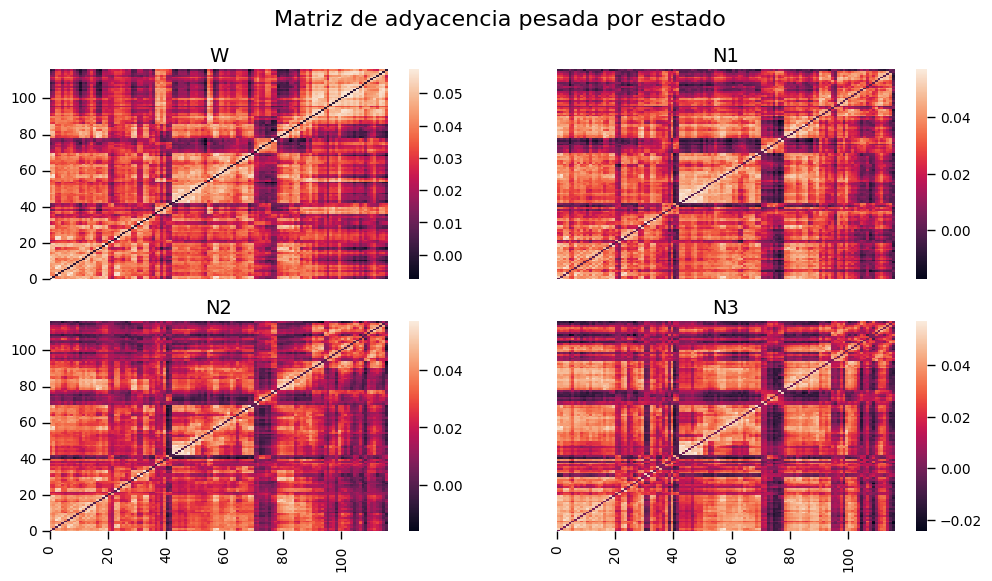

In [35]:
# Function to create a heatmap for a given estado
def create_heatmap(ax, estado):
    heatmap = sns.heatmap(matriz_promedio(estado), ax=ax, fmt=".3f", annot_kws={"size": 12},
                         #cbar_kws={"shrink": 0.8, "label": "Scale", "orientation": "horizontal", "pad": 0.05}
                          )
    ax.set_title(estado, size=14)
    ax.set_xlim(0, n)
    ax.set_ylim(0, n)

    # Adjust tick spacing here
    tick_spacing = 20  # Set your desired tick spacing
    ax.set_xticks(range(0, n + 1, tick_spacing))
    ax.set_yticks(range(0, n + 1, tick_spacing))
    ax.set_xticklabels(ax.get_xticks(), size=10)  # Adjust x-axis label size
    ax.set_yticklabels(ax.get_yticks(), size=10)  # Adjust y-axis label size

    heatmap.collections[0].colorbar.ax.tick_params(labelsize=10,length=6, width=1)

    ax.tick_params(axis='both', which='both', length=6, width=1)

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
estados = ['W', 'N1', 'N2', 'N3']
plt.suptitle('Matriz de adyacencia pesada por estado', size=16)

n = 116
for i, estado in enumerate(estados):
    ax_i = ax[i // 2, i % 2]
    create_heatmap(ax_i, estado)
    if i < 2:
        ax_i.set_xticks([])  # Hide x-axis ticks for the first two plots
    if i % 2 != 0:
        ax_i.set_yticks([])  # Hide y-axis ticks for the second column

# Adjust layout to prevent clipping of titles
#plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.savefig('matriz_promedio.png')
plt.show()


### Primero comparar como varía el tamaño de la componente gigante (es decir, el porcentaje de nodos que participan en la componente gigante) en función de δ, para todos los estadíos. Interpretar las curvas obtenidas. ¿Qué nos indican los saltos?

In [36]:
def density_to_th(W, d):
    n=W.shape[0]
    tril_idx = np.tril_indices(n,-1)
    c = sorted(np.array(list(W[tril_idx].reshape(-1))), reverse=True)
    return c[int((len(c)-1)*d)]

In [37]:
def porcentaje(matriz,densidad):
  matriz_promedio_no_pesada = matriz>=density_to_th(matriz,densidad)
  G = nx.from_numpy_array(matriz_promedio_no_pesada)
  # Calcular la componente gigante del grafo
  componente_gigante = max(nx.connected_components(G), key=len)
  # Calcular el porcentaje de nodos que participan en la componente gigante
  return len(componente_gigante) / len(G)

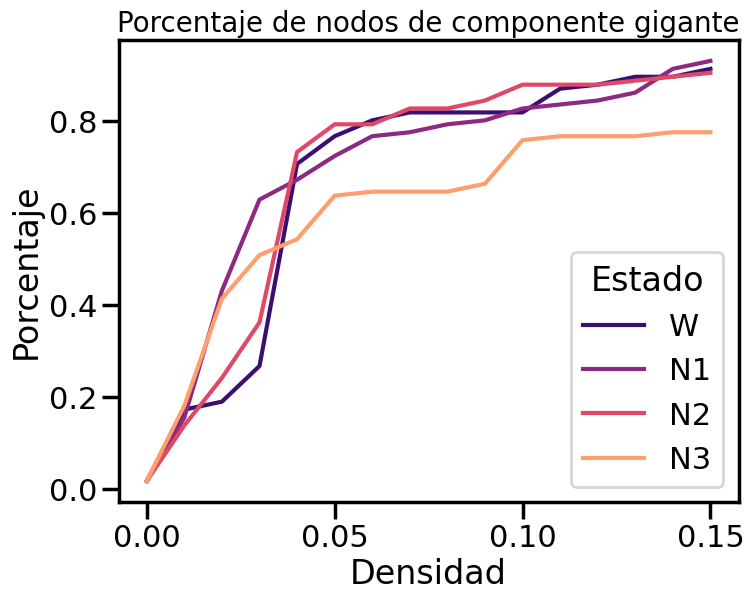

In [38]:
estados = ['W','N1','N2','N3']
densidades = np.arange(0,0.16,0.01)
porcentajes = pd.DataFrame(index=estados)
color_palette = sns.color_palette('magma', n_colors=len(estados))
plt.title('Porcentaje de nodos de componente gigante',size=20)

for i, estado in enumerate(estados):
    for densidad in densidades:
        porcentajes.loc[estado, densidad] = porcentaje(matriz_promedio(estado), densidad)

    # Plot each state with a color from the palette
    plt.plot(densidades, porcentajes.loc[estado], label=estado, color=color_palette[i])

plt.xlabel('Densidad')
plt.ylabel('Porcentaje')
plt.legend(title='Estado')
plt.savefig('grafo_binarizado.png', bbox_inches = 'tight')
plt.show()

Los saltos en las curvas indica que el componente gigante se conectó con un grafo también grande, lo cual hace que la densidad ascienda abruptamente.

Es el mismo gráfico, cambie un poquito la estética nomas

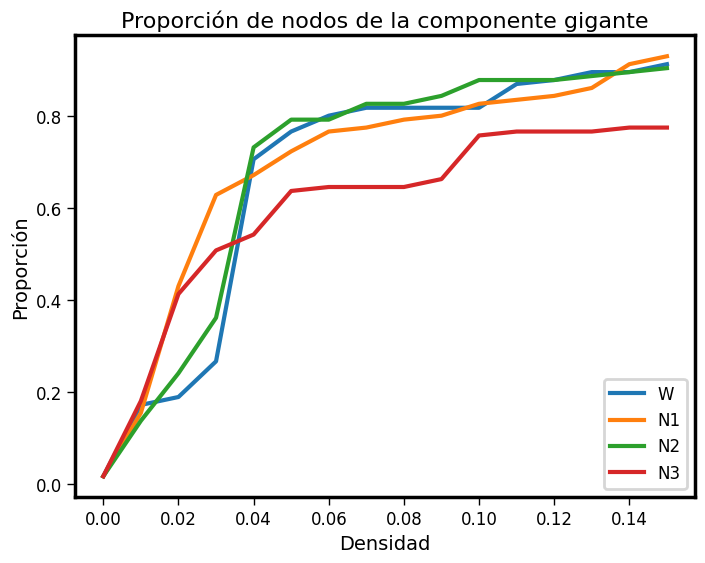

In [39]:
estados = ['W', 'N1', 'N2', 'N3']
densidades = np.arange(0, 0.16, 0.01)
porcentajes = pd.DataFrame(index=estados)

plt.title('Proporción de nodos de la componente gigante', size=16)

for estado in estados:
    for densidad in densidades:
        porcentajes.loc[estado, densidad] = porcentaje(matriz_promedio(estado), densidad)

    # Change font size of axis labels
    plt.xlabel('Densidad', fontsize=14)
    plt.ylabel('Proporción', fontsize=14)
    plt.tick_params('both', length=6, width=1, labelsize=12)
    porcentajes.loc[estado].plot(legend=estado)

plt.legend(fontsize=12, loc = "lower right")
# Show the plot
plt.show()


La densidad es utilizada como umbral (threshold) para binarizar la matriz de correlación entre las señales BOLD de las 116 regiones cerebrales (matriz pesada). Si la densidad de enlaces aumenta, el umbral (correlación o peso del enlace) disminuye, indicando que existen conexiones entre regiones para valores menores de correlación. Es decir, a mayor densidad de enlaces, más conexiones entre regiones cerebrales, por lo tanto la componente gigante va siendo mayor.
Los estadios W y N3 presentan un aumento muy importante del tamaño de la componente gigante con un aumento de densidad de 0.02 a 0.03.

### Elegir uno de los saltos y visualizar los grafos correspondientes para valores de δ justo antes y justo después del salto. Para esta, y todas las visualizaciones de grafos de este TP, representar siempre a los nodos en sus respectivas coordenadas cerebrales.

In [40]:
def grafo_densidad(matriz,densidad):
  matriz_promedio_no_pesada = matriz>=density_to_th(matriz,densidad)
  G = nx.from_numpy_array(matriz_promedio_no_pesada)
  return G

Al ejececutarlo con la nueva matriz binarizada, debieran desaparecer los autoenlaces

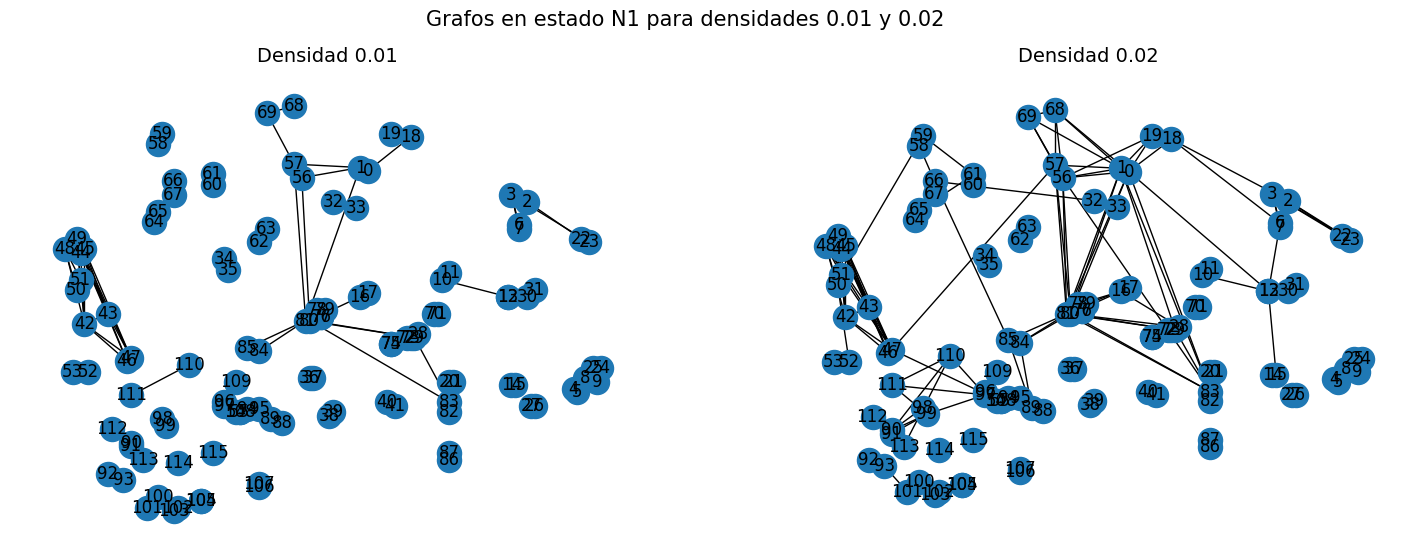

In [41]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
layout = dict(zip(range(116),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

plt.suptitle('Grafos en estado N1 para densidades 0.01 y 0.02',size=15)
for n,densidad in enumerate([0.01,0.02]):
  G = grafo_densidad(matriz_promedio('N1'),densidad)
  nx.draw(G,layout, with_labels=True, linewidths =1,ax=ax[n])
  ax[n].set_title(f'Densidad {densidad}', fontsize=14)

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\sit

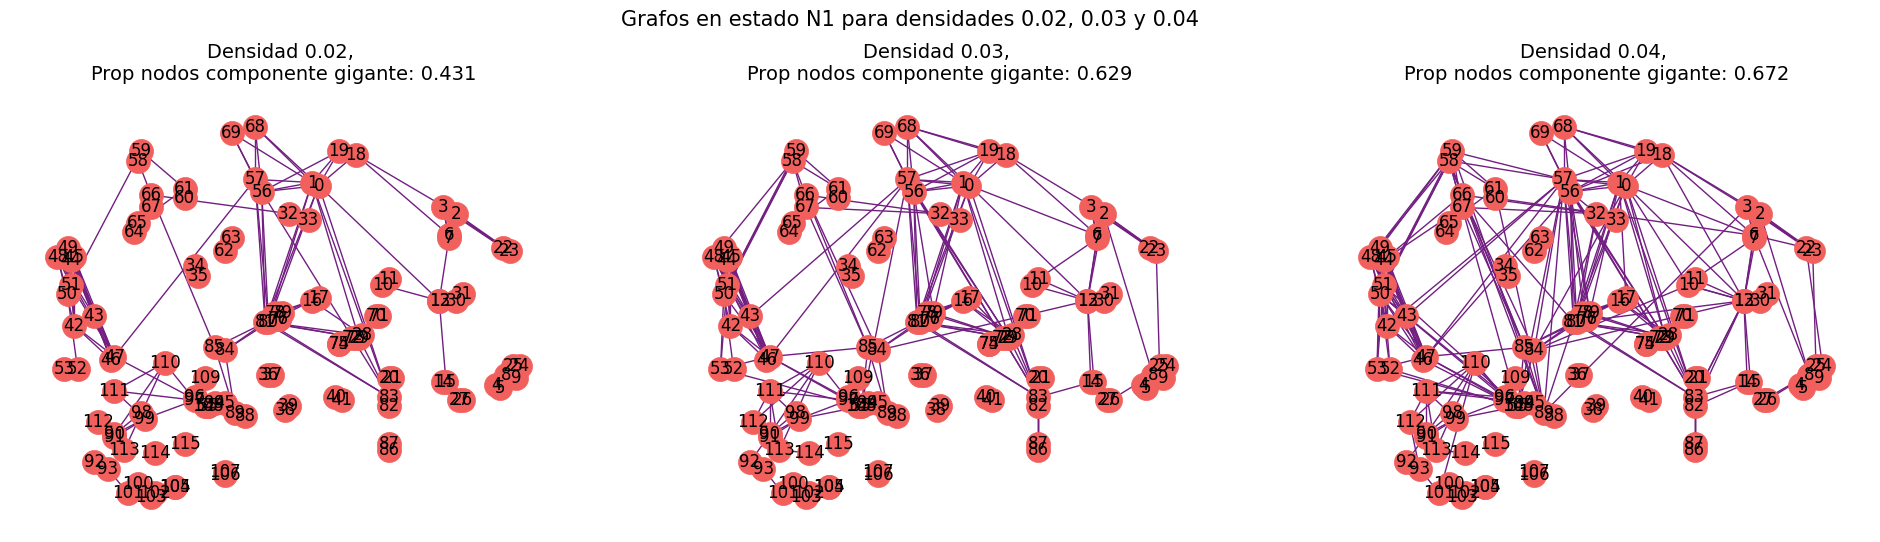

In [42]:
colores = sns.color_palette('magma', n_colors=2)
fig, ax = plt.subplots(1,3,figsize=(24,6), gridspec_kw={'top': 0.85})
layout = dict(zip(range(116),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

plt.suptitle('Grafos en estado N1 para densidades 0.02, 0.03 y 0.04',size=15)
for n,densidad in enumerate([0.02, 0.03,0.04]):
  G = grafo_densidad(matriz_promedio('N1'),densidad)
  nx.draw(G,layout, with_labels=True, linewidths =0.5,ax=ax[n],node_color = colores[1], edge_color = colores[0])

  porcentajes_value = porcentajes.loc['N1', densidad]
  #ax[n].set_title(f'Densidad {densidad}', fontsize=14)
  ax[n].set_title(f'Densidad {densidad}, \nProp nodos componente gigante: {porcentajes_value:.3}', fontsize=14)

plt.savefig('salto_N1.png',bbox_inches = 'tight')
plt.show()

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\sit

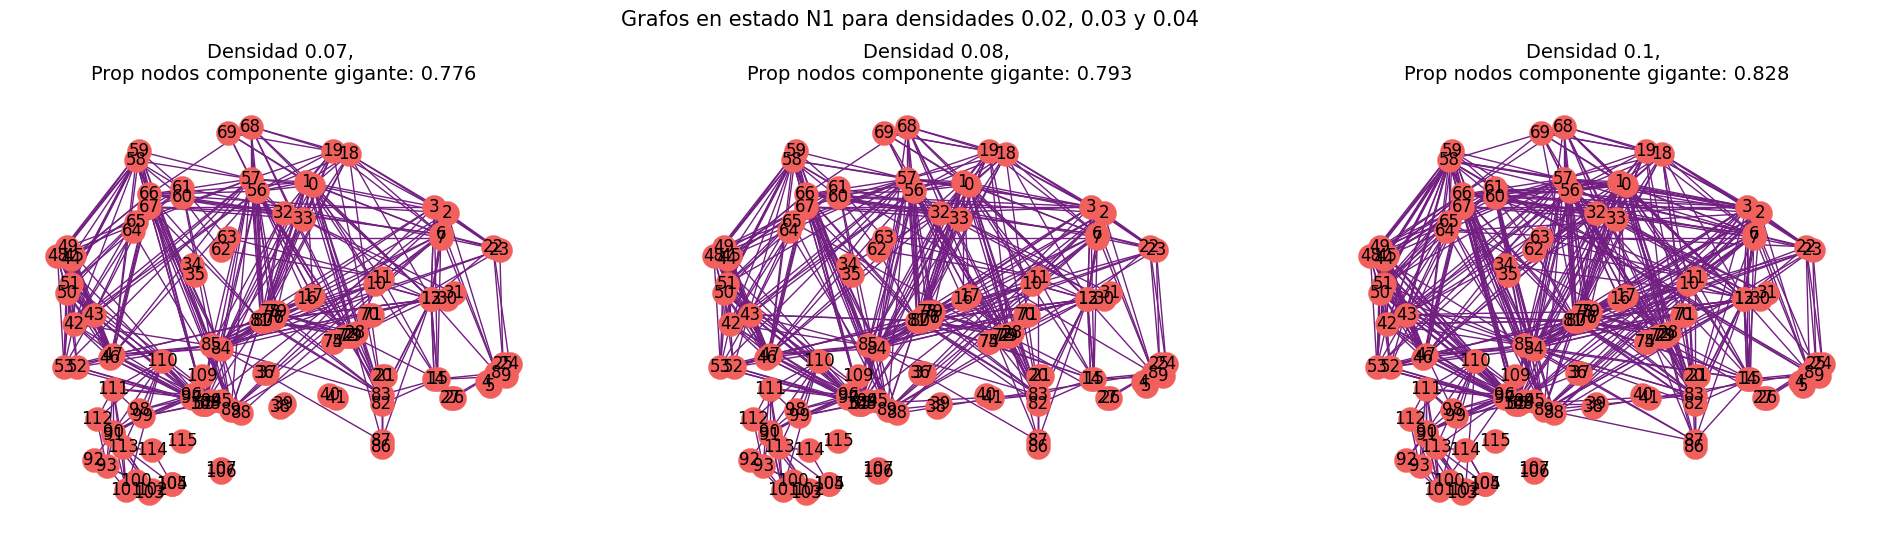

In [43]:
colores = sns.color_palette('magma', n_colors=2)

fig, ax = plt.subplots(1,3,figsize=(24,6), gridspec_kw={'top': 0.85})
layout = dict(zip(range(116),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

plt.suptitle('Grafos en estado N1 para densidades 0.02, 0.03 y 0.04',size=15)
for n,densidad in enumerate([0.07, 0.08,0.1]):
  G = grafo_densidad(matriz_promedio('N1'),densidad)
  nx.draw(G,layout, with_labels=True, linewidths =0.3,ax=ax[n],node_color = colores[1], edge_color = colores[0])

  porcentajes_value = porcentajes.loc['N1', densidad]
  #ax[n].set_title(f'Densidad {densidad}', fontsize=14)
  ax[n].set_title(f'Densidad {densidad}, \nProp nodos componente gigante: {porcentajes_value:.3}', fontsize=14)

#plt.savefig('salto_N1.png',bbox_inches = 'tight')
plt.show()

Se torna muy evidente el aumento en la conectividad de los nodos para el estadio N1 al incrementar la densidad en un 1% de 0.03 a 0.04. La proporción de nodos que participan en la componente gigante pasa del 24% al 60% con dicho incremento de densidad.

### Graficar como varía el grado medio, el coeficiente de clustering medio, y la eficiencia global en función de δ. Interpretar curvas.

In [44]:
def metricas(matriz,densidad):
  matriz_promedio_no_pesada = matriz>=density_to_th(matriz,densidad)
  G = nx.from_numpy_array(matriz_promedio_no_pesada)
  # Calcular el grado de cada nodo
  grados = [G.degree(node) for node in G.nodes()]
  # Calcular el grado medio del grafo
  grado_medio = sum(grados) / len(grados)

  clustering_medio = nx.average_clustering(G)

  eficiencia_global = nx.global_efficiency(G)

  return grado_medio, clustering_medio, eficiencia_global

In [53]:
metricas_dict = {}

for estado in estados:
  metricas_dict[estado] = pd.DataFrame()
  for densidad in densidades:
    medidas = metricas(matriz_promedio(estado),densidad)
    metricas_dict[estado].loc[densidad,'grado_medio'      ] = medidas[0]
    metricas_dict[estado].loc[densidad,'clustering_medio' ] = medidas[1]
    metricas_dict[estado].loc[densidad,'eficiencia_global'] = medidas[2]

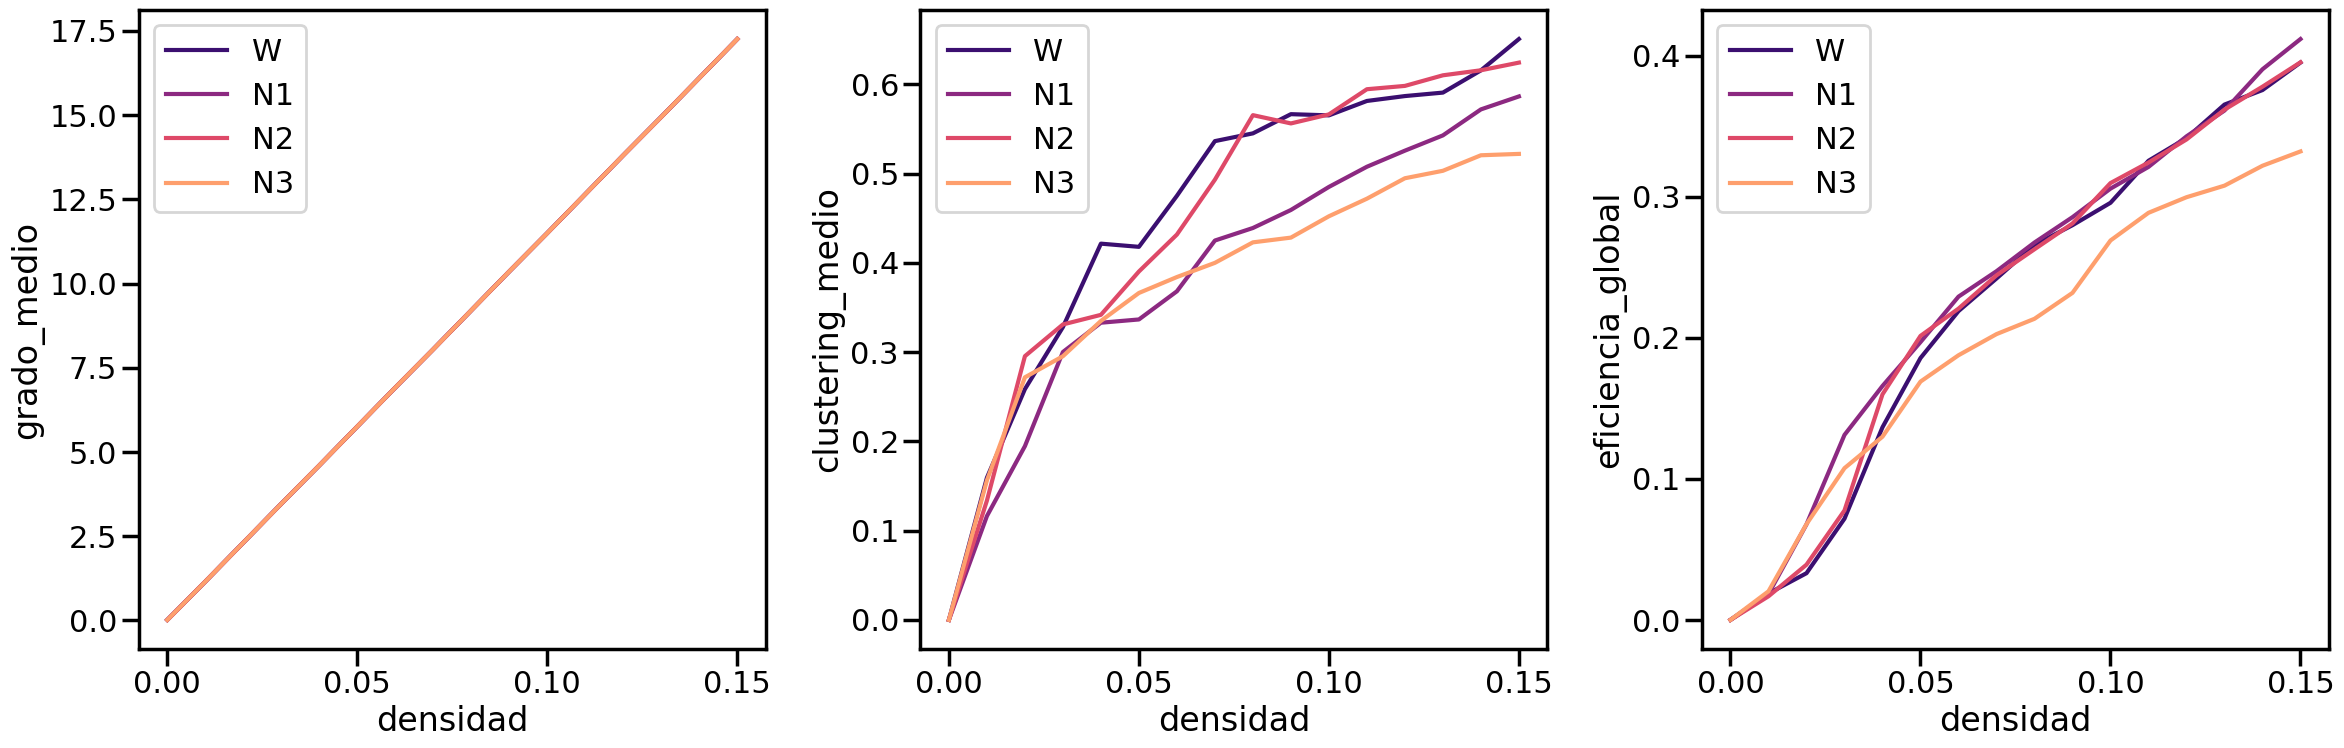

In [62]:
# Define a seaborn color palette
palette = sns.color_palette('magma', n_colors=len(estados))

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(24, 8))
#plt.suptitle('Metricas según estado y densidad')

for n, metrica in enumerate(['grado_medio', 'clustering_medio', 'eficiencia_global']):
    ax[n].set(xlabel='densidad', ylabel=metrica)

    # Iterate through states and plot each line individually
    for i, estado in enumerate(estados):
        ax[n].plot(metricas_dict[estado][metrica], label=estado, color=palette[i])

    ax[n].legend()

# Adjust layout to prevent cutting off labels
plt.tight_layout()

plt.savefig('metricas.png',bbox_inches = 'tight')
plt.show()


### Para un valor de δ=0.12 visualizar el grafo de cada estadío, donde el color del nodo i esté dado a su centralidad de autovector ceigen i , y su tamaño sea proporcional a αceigen i (donde α es una constante que debemos elegir para ayudar la visualización). ¿Se observan cambios entre estadíos?

Debieran desaparecer los autoenlaces cuando lo ejecuten de nuevo

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


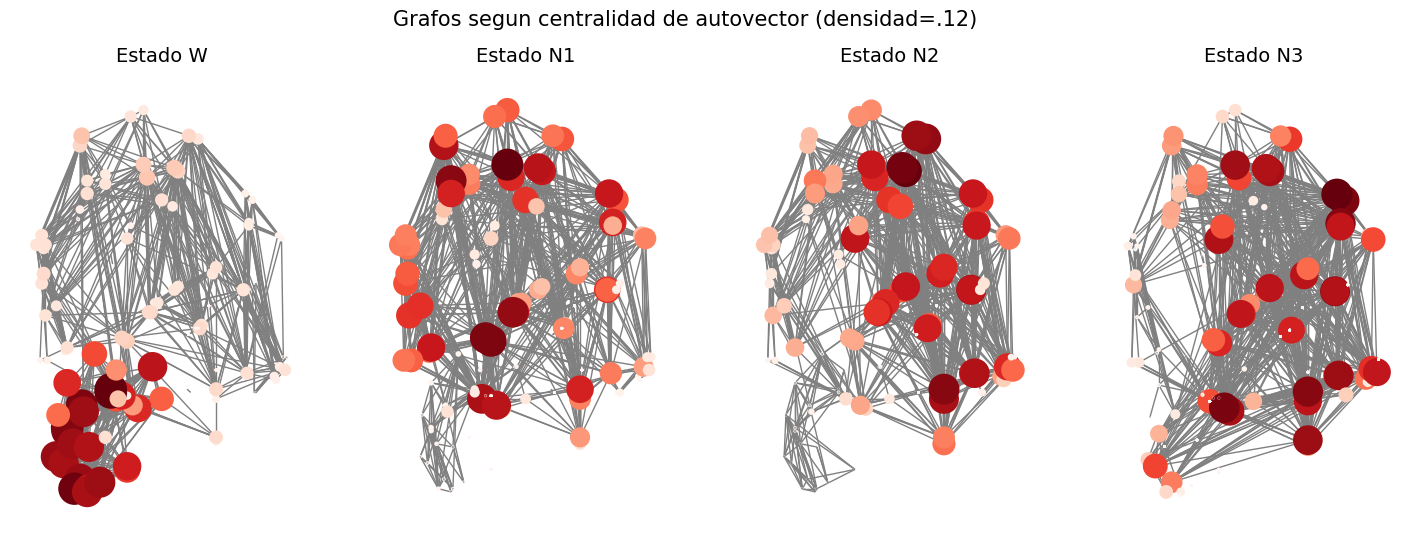

In [47]:
fig, ax = plt.subplots(1,4,figsize=(18,6))
layout = dict(zip(range(116),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
alpha = 2000

plt.suptitle('Grafos segun centralidad de autovector (densidad=.12)',size=15)
for n,estado in enumerate(estados):
  G = grafo_densidad(matriz_promedio(estado),.12)
  autovectores = list(nx.eigenvector_centrality_numpy(G).values())
  nx.draw(G,layout, with_labels=False,ax=ax[n],cmap=plt.cm.Reds,
          node_color=autovectores,node_size=[x*alpha for x in autovectores], edge_color='gray')
  ax[n].set_title(f'Estado {estado}', fontsize=14)

Cambio un poco la estetica por si interesa

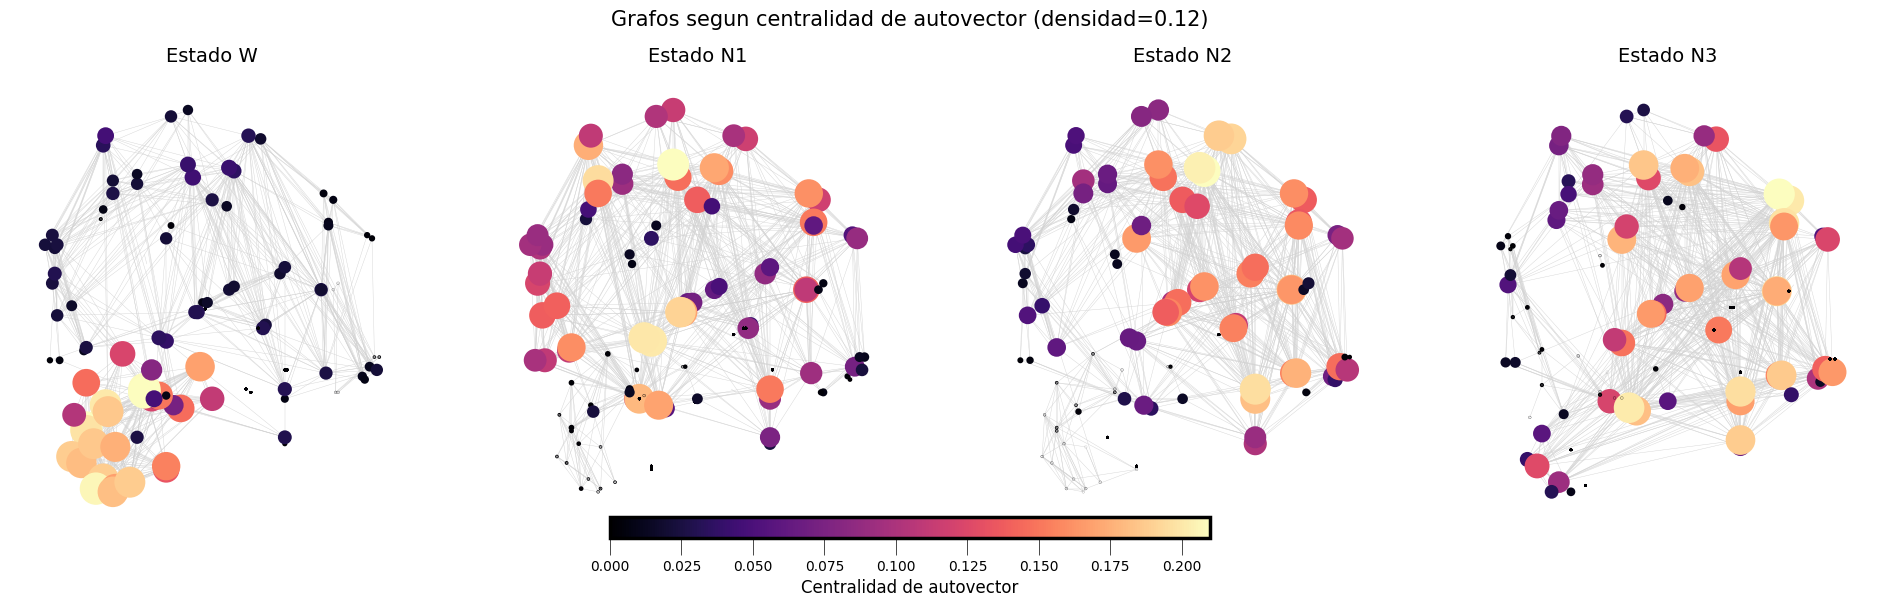

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

fig, ax = plt.subplots(1, 4, figsize=(24, 6))
layout = dict(zip(range(116), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
alpha = 2000

plt.suptitle('Grafos segun centralidad de autovector (densidad=0.12)', size=15)

for n, estado in enumerate(estados):
    G = grafo_densidad(matriz_promedio(estado), .12)
    autovectores = np.array(list(nx.eigenvector_centrality_numpy(G).values()))

    # Check for NaN or negative values and replace them with 0
    valid_autovectores = np.where(np.isnan(autovectores) | (autovectores < 0), 0, autovectores)

    # Plot the graph
    node_colors = valid_autovectores
    cmap = sns.color_palette('magma', as_cmap=True)
    norm = Normalize(vmin=min(node_colors), vmax=max(node_colors))
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Need an empty array for the scalar mappable

    nx.draw(G, layout, with_labels=False, ax=ax[n], cmap=cmap,
            node_color=node_colors, node_size=[x * alpha for x in valid_autovectores], edge_color='lightgray', width=0.3)

    ax[n].set_title(f'Estado {estado}', fontsize=14)

# Add horizontal colorbar with adjusted size and position
cbar_ax = fig.add_axes([0.375, 0.1, 0.25, 0.035])  # Adjust the values [left, bottom, width, height] according to your preference
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Centralidad de autovector', fontsize=12)  # Set the fontsize for the colorbar label
cbar.ax.tick_params(labelsize=10, width=0.5)  # Adjust the fontsize and width of colorbar tick labels
cbar.ax.xaxis.set_tick_params(width=0.5)  # Adjust the width of the colorbar itself

# plt.savefig('centralidad_autovector.png', bbox_inches='tight')
plt.show()


## Tarea 2: Comunidades y coeﬁciente de modularidad

Vamos a analizar como varía la modularidad entre los sujetos de cada estadío, en función de δ (como siempre, en el rango δ=0-0.15). De aquí en adelante, siempre que se graﬁquen curvas promedio, se deben graﬁcar con una noción de incerteza (el error estandard de la media)

### 1.

Para cada sujeto de cada estadío generar grafos variando δ, determinar comunidades en dichos grafos a partir de algoritmo de Louvain [Blondel et al., 2008], y calcular la curva que describa el coeﬁciente de modularidad (Q) en función de δ. Promediando entre sujetos de cada estadío, obtener la curva correspondiente a cada estadío. Compararlas con las curvas de Q en función de δ para “modelos nulos” equivalentes: usando grafos random de igual cantidad total de nodos e igual densidad de enlaces δ. Para cada valor de δ incluir un test de signiﬁcancia clásico para diferencias entre el grafo observado y el modelo nulo de grafo azar (marcar con un asterico las comparciones signiﬁcativas). Discutir los resultados.

In [49]:
# %pip install python-louvain
import community.community_louvain as cl

Text(0, 0.5, 'modularidad')

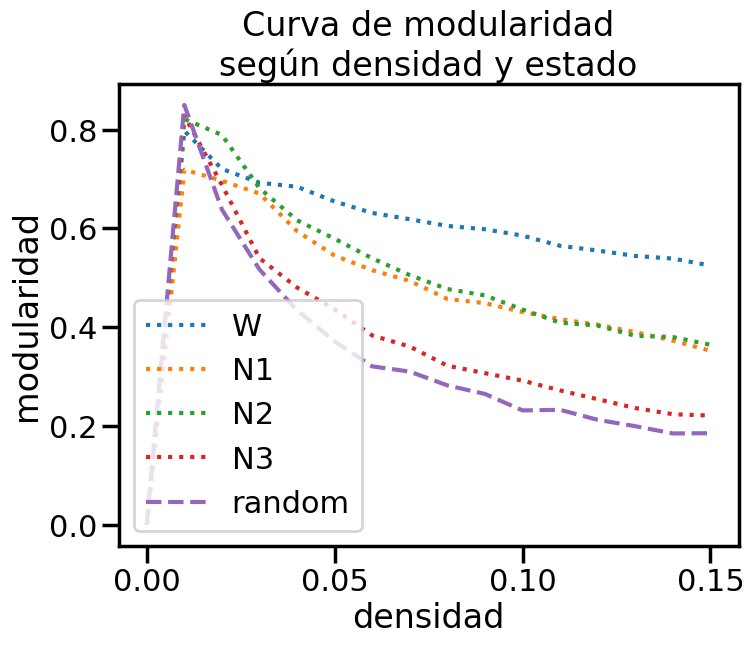

In [76]:
plt.figure(figsize=(8,6))
modularidades = pd.DataFrame()
for estado in estados:
    for densidad in densidades:
        G = grafo_densidad(matriz_promedio(estado), densidad)
        modulos = cl.best_partition(G)
        modularidades.loc[densidad,estado] = cl.modularity(modulos, G)

        if estado=='N3':
            R = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges(),seed=42)
            modulos_R = cl.best_partition(R)
            modularidades.loc[densidad,'random'] = cl.modularity(modulos_R, R)

    plt.plot(modularidades[estado], linestyle='dotted',label=estado)
plt.plot(modularidades['random'], linestyle='dashed',label='random')
plt.legend()
plt.title('Curva de modularidad\nsegún densidad y estado')
plt.xlabel('densidad')
plt.ylabel('modularidad')

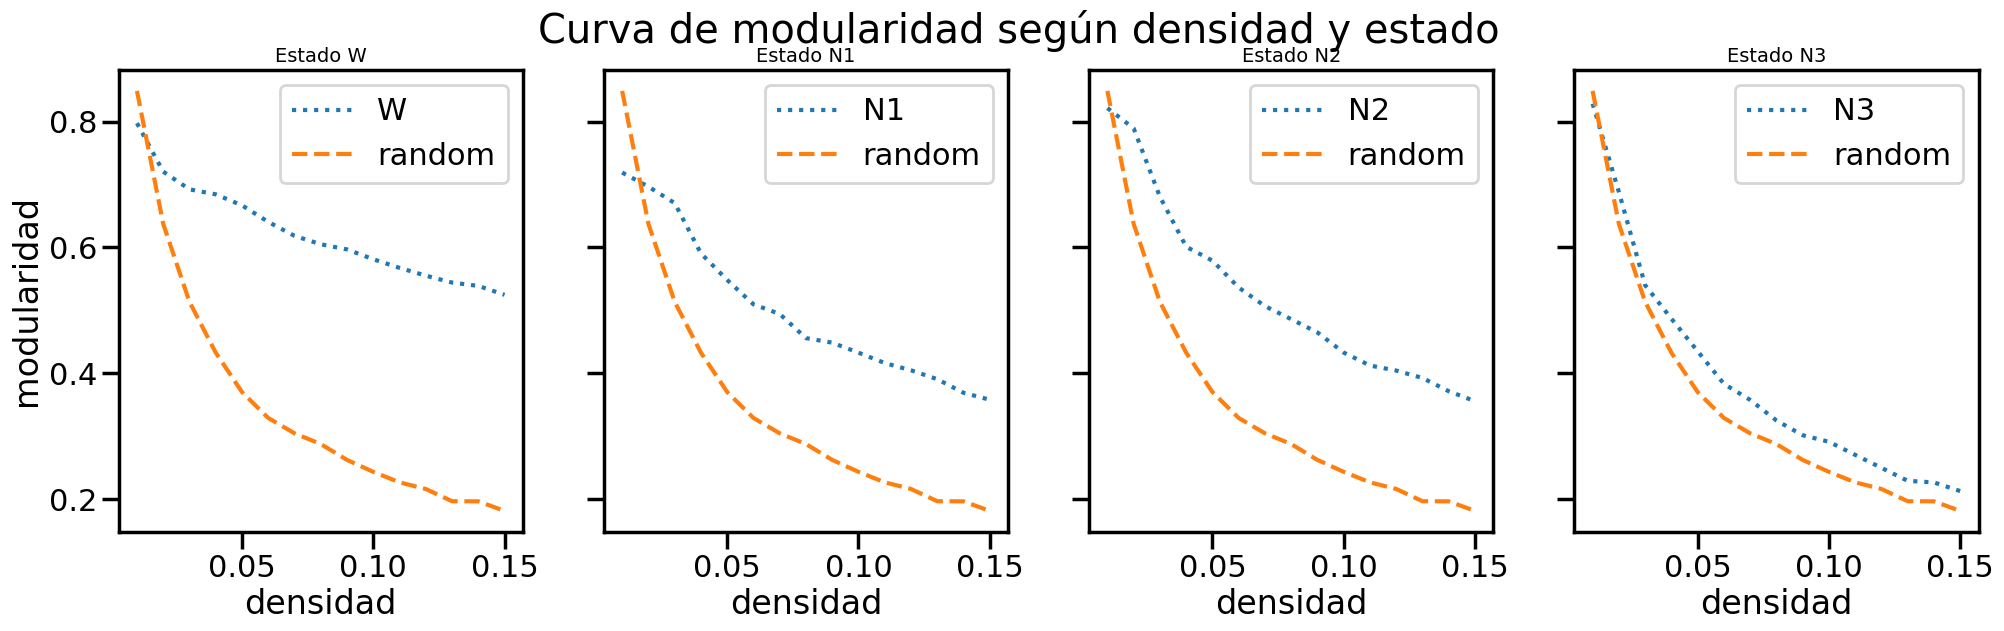

In [91]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(24,6))
modularidades = pd.DataFrame()
for n,estado in enumerate(estados):
    for densidad in densidades:
        if densidad!=0:
            G = grafo_densidad(matriz_promedio(estado), densidad)
            modulos = cl.best_partition(G)
            modularidades.loc[densidad,estado] = cl.modularity(modulos, G)
            if n==0:
                R = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges(),seed=42)
                modulos_R = cl.best_partition(R)
                modularidades.loc[densidad,'random'] = cl.modularity(modulos_R, R)

    ax[n].plot(modularidades[estado], linestyle='dotted',label=estado)
    ax[n].plot(modularidades['random'], linestyle='dashed',label='random')
    ax[n].set_title(f'Estado {estado}', fontsize=14)
    ax[n].legend()
    ax[n].set_xlabel('densidad')
    
    if n==0:
        ax[n].set_ylabel('modularidad')
    else:
        ax[n].set_yticklabels([])

plt.suptitle('Curva de modularidad según densidad y estado');

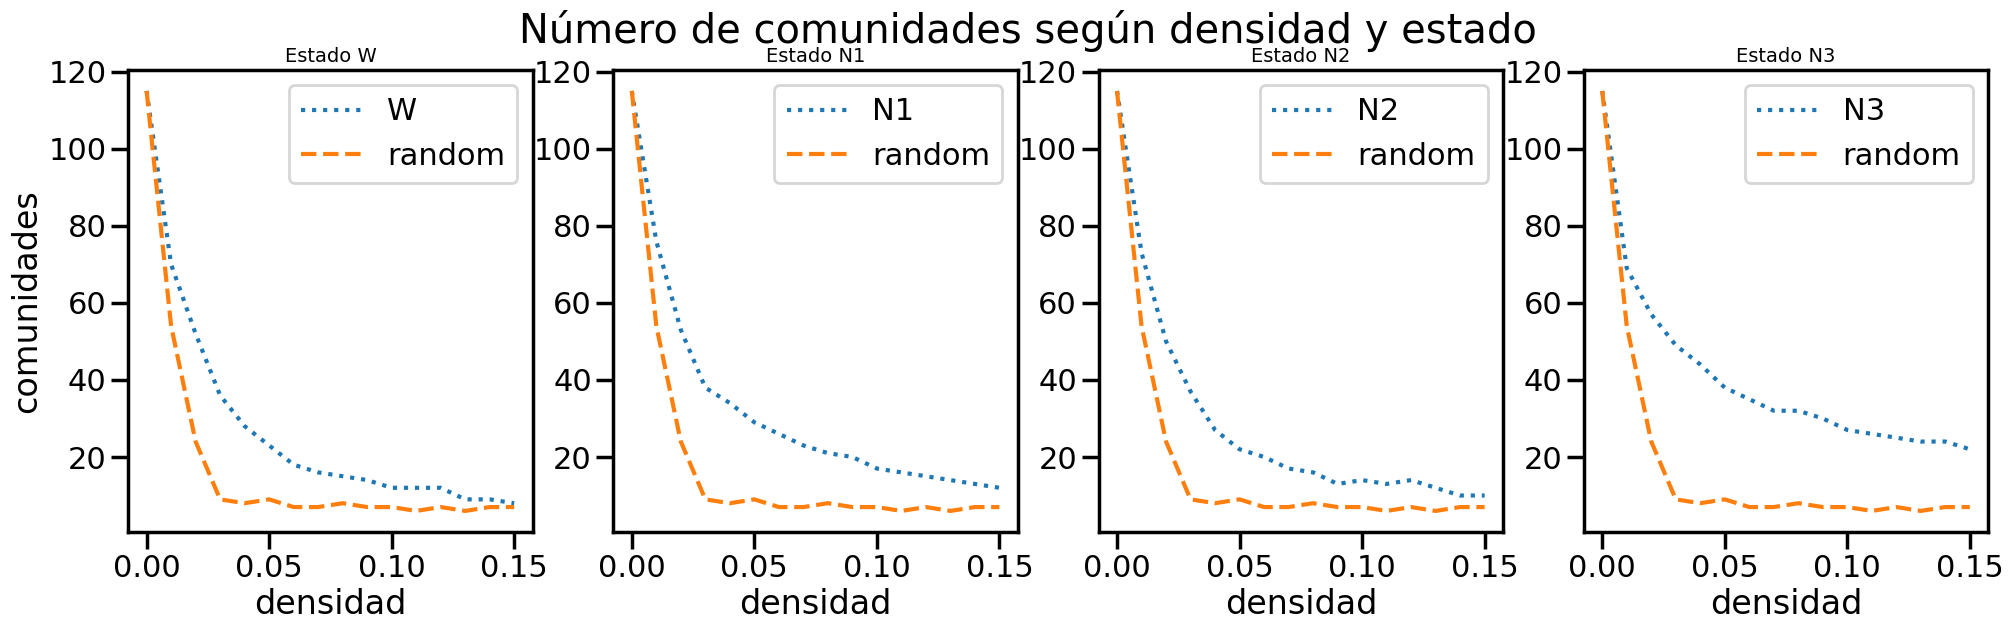

In [208]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(24,6))
modularidades = pd.DataFrame()
for n,estado in enumerate(estados):
    for densidad in densidades:
        # if densidad!=0:
            G = grafo_densidad(matriz_promedio(estado), densidad)
            modulos = cl.best_partition(G)
            modularidades.loc[densidad,estado] = len(set(modulos.values()))
            if n==0:
                R = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges(),seed=42)
                modulos_R = cl.best_partition(R)
                modularidades.loc[densidad,'random'] = len(set(modulos_R.values()))

    ax[n].plot(modularidades[estado], linestyle='dotted',label=estado)
    ax[n].plot(modularidades['random'], linestyle='dashed',label='random')
    ax[n].set_title(f'Estado {estado}', fontsize=14)
    ax[n].legend()
    ax[n].set_xlabel('densidad')
    
    if n==0:
        ax[n].set_ylabel('comunidades')
    # else:
        # ax[n].set_yticklabels([])

plt.suptitle('Número de comunidades según densidad y estado');

# otras pruebas

In [307]:
sujetos_list = sujetos.index[sujetos.index.str.contains(estado)]
curvas = pd.DataFrame(index=['sujeto','estado','densidad','comunidades','modularidad','comunidades_random','modularidad_random'])
densidades = np.arange(0.01,0.16,0.01)
for estado in estados:    
    for densidad in densidades:        
        for sujeto in sujetos_list:
            # print(sujeto)
            G = grafo_densidad(pd.read_csv('DataSujetos/'+sujeto,header=None).values, densidad)
            # print(G.number_of_nodes())
            # print(G.number_of_edges())
            R = nx.erdos_renyi_graph(n=G.number_of_nodes(), p=densidad,seed=42)
            modulos_louvain = cl.best_partition(G)
            modulos_louvain_random = cl.best_partition(R)
            aux = pd.Series()
            aux['estado'] = estado
            aux['sujeto'] = sujeto
            aux['densidad'] = densidad
            aux['comunidades'] = len(set(modulos_louvain.values()))
            aux['modularidad'] = cl.modularity(modulos_louvain, G)
            aux['comunidades_random'] = len(set(modulos_louvain_random.values()))
            aux['modularidad_random'] = cl.modularity(modulos_louvain_random, R)
            curvas = pd.concat((curvas,aux.T),axis=1)
curvas = curvas.T.set_index(['estado','densidad','sujeto'])

In [364]:
def estado_vs_random(metrica):
    fig, ax = plt.subplots(1,4,figsize=(24,6))
    plt.suptitle(f'{metrica} promedio por estado y densidad',size=20)
    for n,estado in enumerate(estados):
        test = curvas.loc[estado].groupby('densidad').mean()
        ax[n].plot(test[metrica],label=estado)
        ax[n].plot(test[metrica+'_random'],label='random')
        
        # hacemos t-test    
        p_value = {}
        p_value[estado] = pd.Series(index=densidades)
        for densidad in densidades:
        # HACER T TEST ENTRE MODULARIDAD Y MODULARIDAD RANDOM EN CADA DENSIDAD
            t = ttest_ind(curvas.loc[(estado,densidad),metrica].astype(float),
                        curvas.loc[(estado,densidad),metrica+'_random'].astype(float))[1]
            p_value[estado][densidad] = t
        
        
        # ax[n].plot(p_mod[estado], marker='o', linestyle='', color='black')
        for densidad, p_value in p_value[estado].items():
            if p_value < 0.05:
                ax[n].text(densidad, test[metrica].min()*.4, '*', fontsize=20, color='green')
        ax[n].legend()
        ax[n].set_title(f'Estado {estado}', fontsize=14)
        ax[n].set_xlabel('densidad')
        # ax[n].set_ylabel('modularidad')
        if n==0: 
            ax[n].set_ylabel(metrica)   

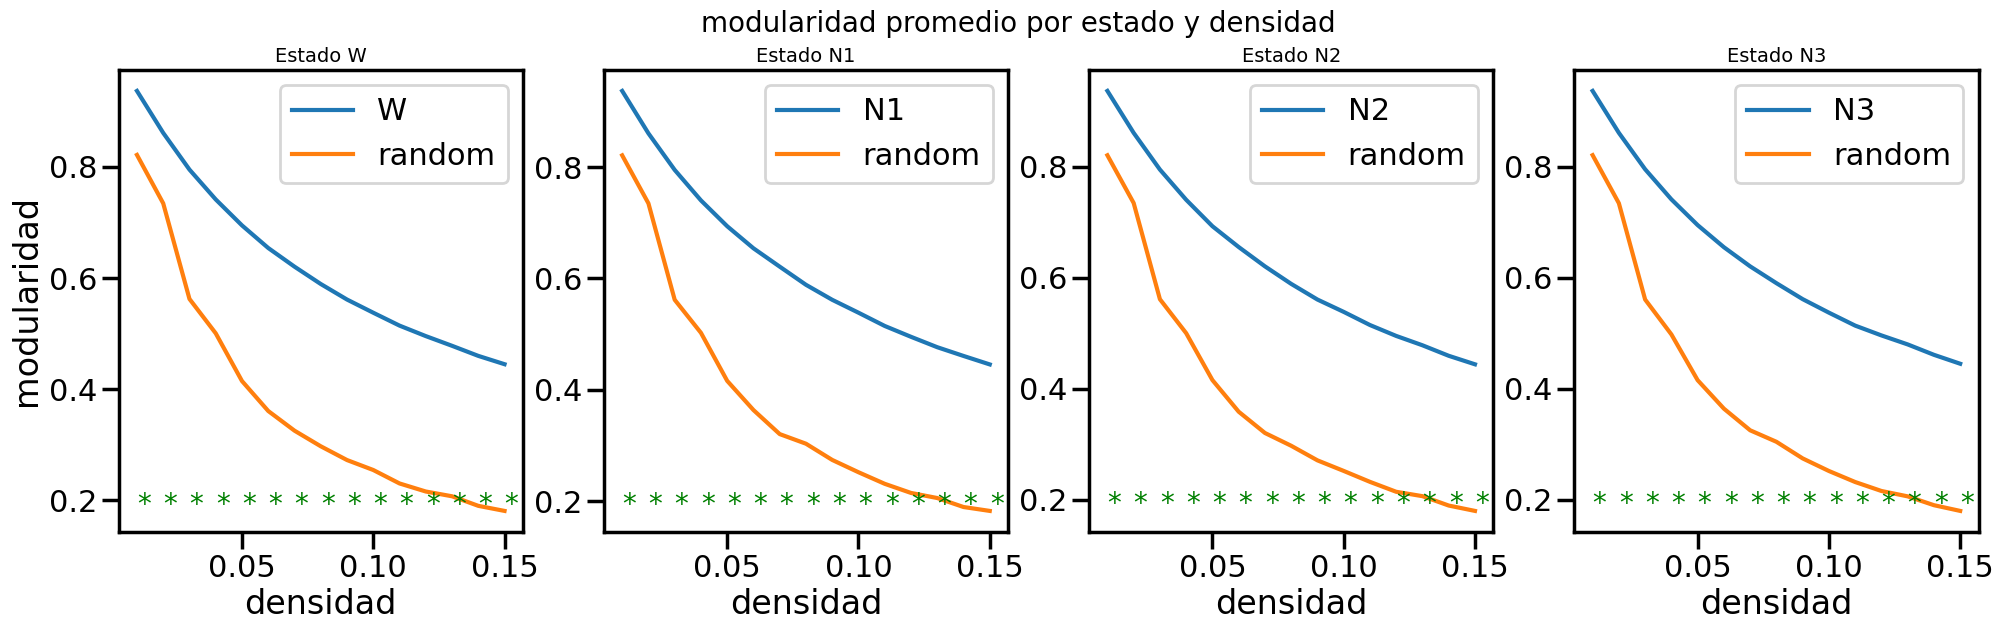

In [367]:
# remove warnings
import warnings
warnings.filterwarnings('ignore') # el t test me imprime banda de warnings, andá a saber si es robusto
estado_vs_random('modularidad')

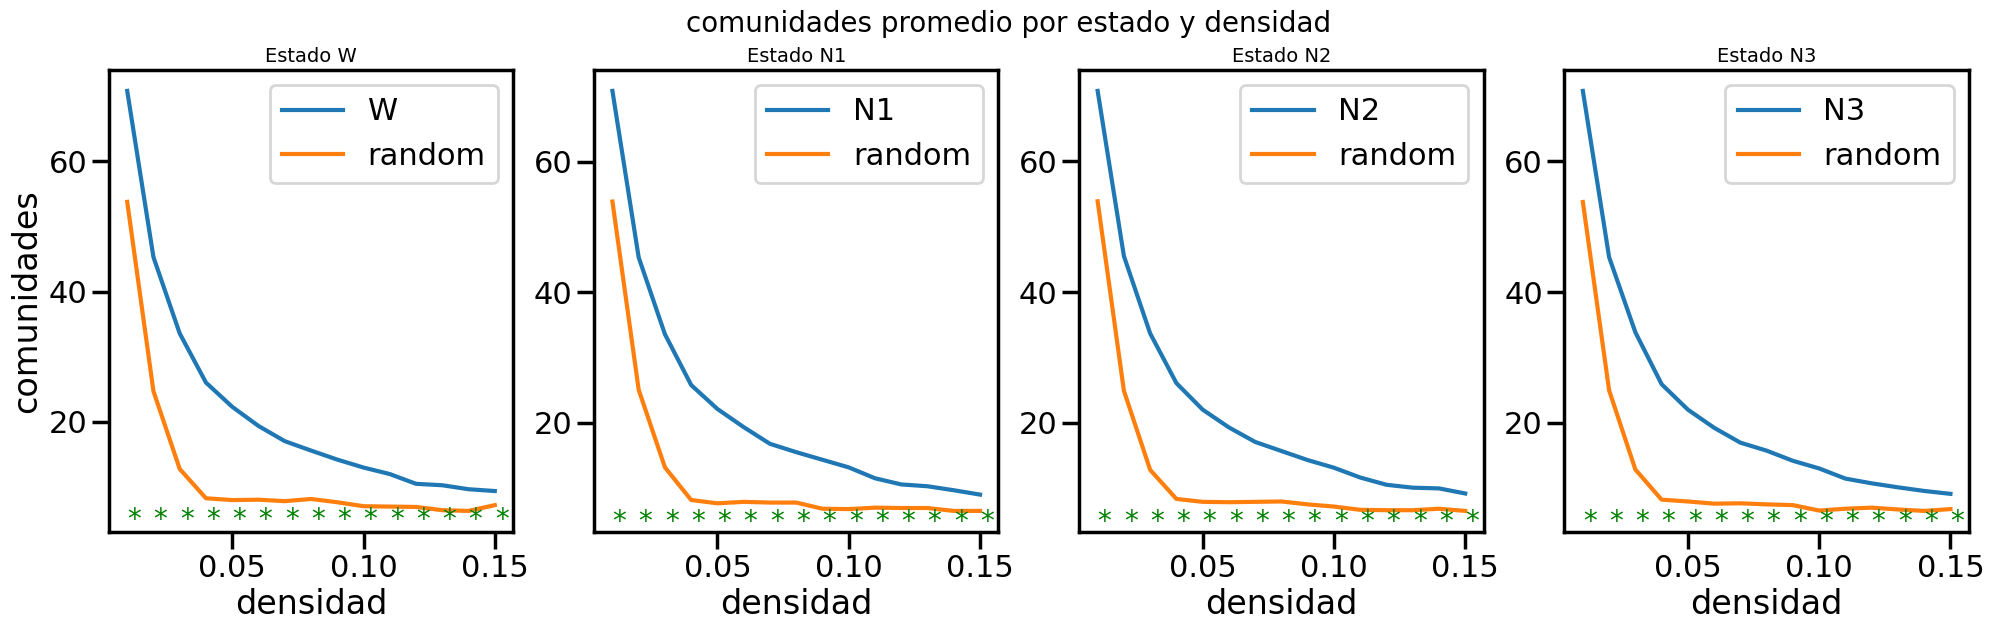

In [368]:
estado_vs_random('comunidades')

In [397]:
# no se por qué pero los promedio me vienen dando todos muy parecidos
pd.concat((curvas.loc['W'].groupby('densidad').mean() ['modularidad'],
           curvas.loc['N1'].groupby('densidad').mean()['modularidad'],
           curvas.loc['N2'].groupby('densidad').mean()['modularidad'],
           curvas.loc['N3'].groupby('densidad').mean()['modularidad']),axis=1)

modularidad modularidad modularidad modularidad
densidad                                                
0.01        0.936657    0.936654    0.936605    0.936602
0.02         0.86107    0.860398    0.861015    0.860997
0.03        0.795058    0.794746    0.794905     0.79539
0.04        0.741371    0.740019    0.740483    0.741135
0.05        0.694658    0.693613    0.692834    0.694726
0.06        0.653977    0.653992    0.655353     0.65488
0.07        0.620405    0.621011    0.620533    0.620359
0.08        0.589211    0.588433    0.588947    0.590071
0.09        0.561242     0.56147    0.560711    0.561277
0.10        0.537517    0.538313    0.538508    0.536881
0.11        0.514332    0.514486    0.514812    0.513547
0.12        0.495463    0.495019    0.495154    0.495878
0.13        0.477993    0.476345    0.478303    0.479642
0.14        0.459851    0.460653    0.459383    0.460896
0.15        0.444877    0.445417    0.444041    0.444821

In [427]:
ttest_ind(curvas.loc['W'].groupby('densidad').mean()['modularidad' ].astype(float),
          curvas.loc['N1'].groupby('densidad').mean()['modularidad'].astype(float))

TtestResult(statistic=0.003735265800902133, pvalue=0.9970461820803, df=28.0)

In [424]:
# no se por qué pero los promedio me vienen dando todos muy parecidos
pd.concat((curvas.loc['W'].groupby('densidad').mean() ['comunidades'],
           curvas.loc['N1'].groupby('densidad').mean()['comunidades'],
           curvas.loc['N2'].groupby('densidad').mean()['comunidades'],
           curvas.loc['N3'].groupby('densidad').mean()['comunidades']),axis=1)

comunidades comunidades comunidades comunidades
densidad                                                
0.01       70.833333   70.833333   70.777778   70.777778
0.02       45.277778   45.333333        45.5   45.333333
0.03       33.555556   33.555556   33.666667   33.833333
0.04            26.0   25.777778   26.055556   25.888889
0.05       22.277778   22.111111        22.0        22.0
0.06       19.333333   19.333333   19.277778   19.222222
0.07            17.0   16.777778   17.055556   16.944444
0.08       15.555556        15.5   15.666667   15.722222
0.09       14.166667   14.333333   14.277778   14.166667
0.10       12.944444   13.166667   13.111111        13.0
0.11       11.944444        11.5   11.611111   11.444444
0.12       10.444444   10.555556        10.5   10.722222
0.13       10.222222   10.277778   10.055556   10.111111
0.14        9.611111    9.666667    9.944444    9.555556
0.15        9.333333         9.0    9.166667    9.111111

In [440]:
# iterar combinaciones posibles de estado
from itertools import combinations
for n, comb in enumerate(combinations(estados,2)):
    print(comb)
    if n>1:
        break


('W', 'N1')
('W', 'N2')
('W', 'N3')


In [445]:
def estado_vs_estado(metrica):
    fig, ax = plt.subplots(1,3,figsize=(24,6))
    plt.suptitle(f'{metrica} promedio por estado y densidad',size=20)
    for n, comb in enumerate(combinations(estados,2)):
        if n>2: break

        ax[n].plot(curvas.loc[comb[0]].groupby('densidad').mean()[metrica],label=comb[0])
        ax[n].plot(curvas.loc[comb[1]].groupby('densidad').mean()[metrica],label=comb[1])
        
        # hacemos t-test    
        p_value = {}
        p_value[estado] = pd.Series(index=densidades)
        for densidad in densidades:
        # HACER T TEST ENTRE MODULARIDAD Y MODULARIDAD RANDOM EN CADA DENSIDAD
            t = ttest_ind(curvas.loc[comb[0]].groupby('densidad').mean()[metrica].astype(float),
                          curvas.loc[comb[1]].groupby('densidad').mean()[metrica].astype(float))[1]
            p_value[estado][densidad] = t        
        
        # ax[n].plot(p_mod[estado], marker='o', linestyle='', color='black')
        for densidad, p_value in p_value[estado].items():
            if p_value < 0.05:
                # obtain max of the graph
                metrica_min = curvas.loc[comb[0]].groupby('densidad').mean()[metrica].min()
                ax[n].text(densidad, metrica_min, '*',fontsize=20, color='green')
            elif p_value < 0.1:
                metrica_min = curvas.loc[comb[0]].groupby('densidad').mean()[metrica].min()
                ax[n].text(densidad, metrica_min, 'o',fontsize=20, color='orange')
            else:
                metrica_min = curvas.loc[comb[0]].groupby('densidad').mean()[metrica].min()
                ax[n].text(densidad, metrica_min, 'x',fontsize=20, color='red')
        ax[n].legend()
        ax[n].set_title(f"{comb[0]} vs {comb[1]}", fontsize=14)
        ax[n].set_xlabel('densidad')
        # ax[n].set_ylabel('modularidad')
        if n==0: 
            ax[n].set_ylabel(metrica)   

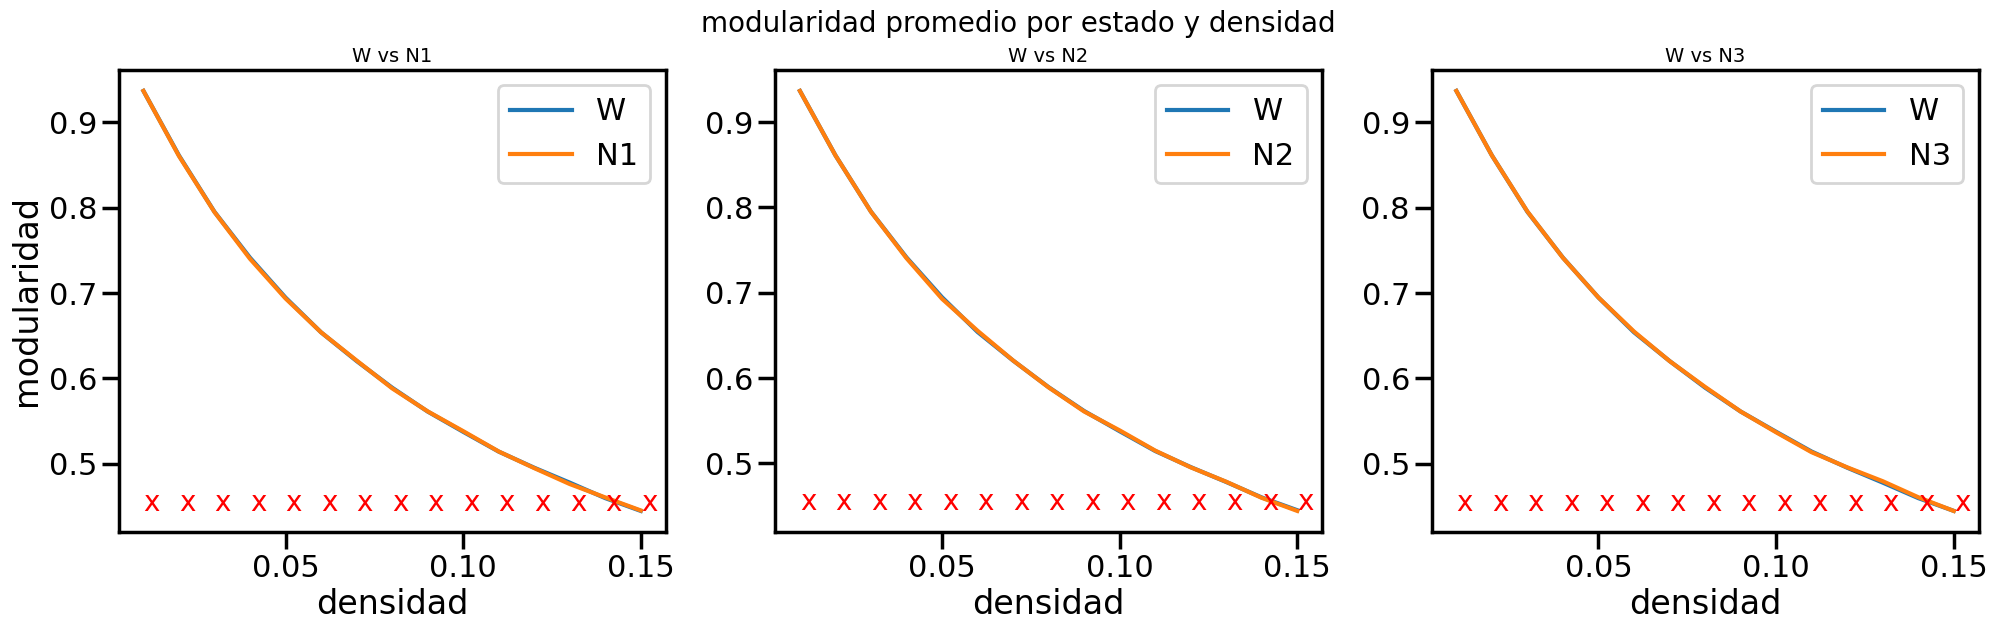

In [446]:
estado_vs_estado('modularidad')

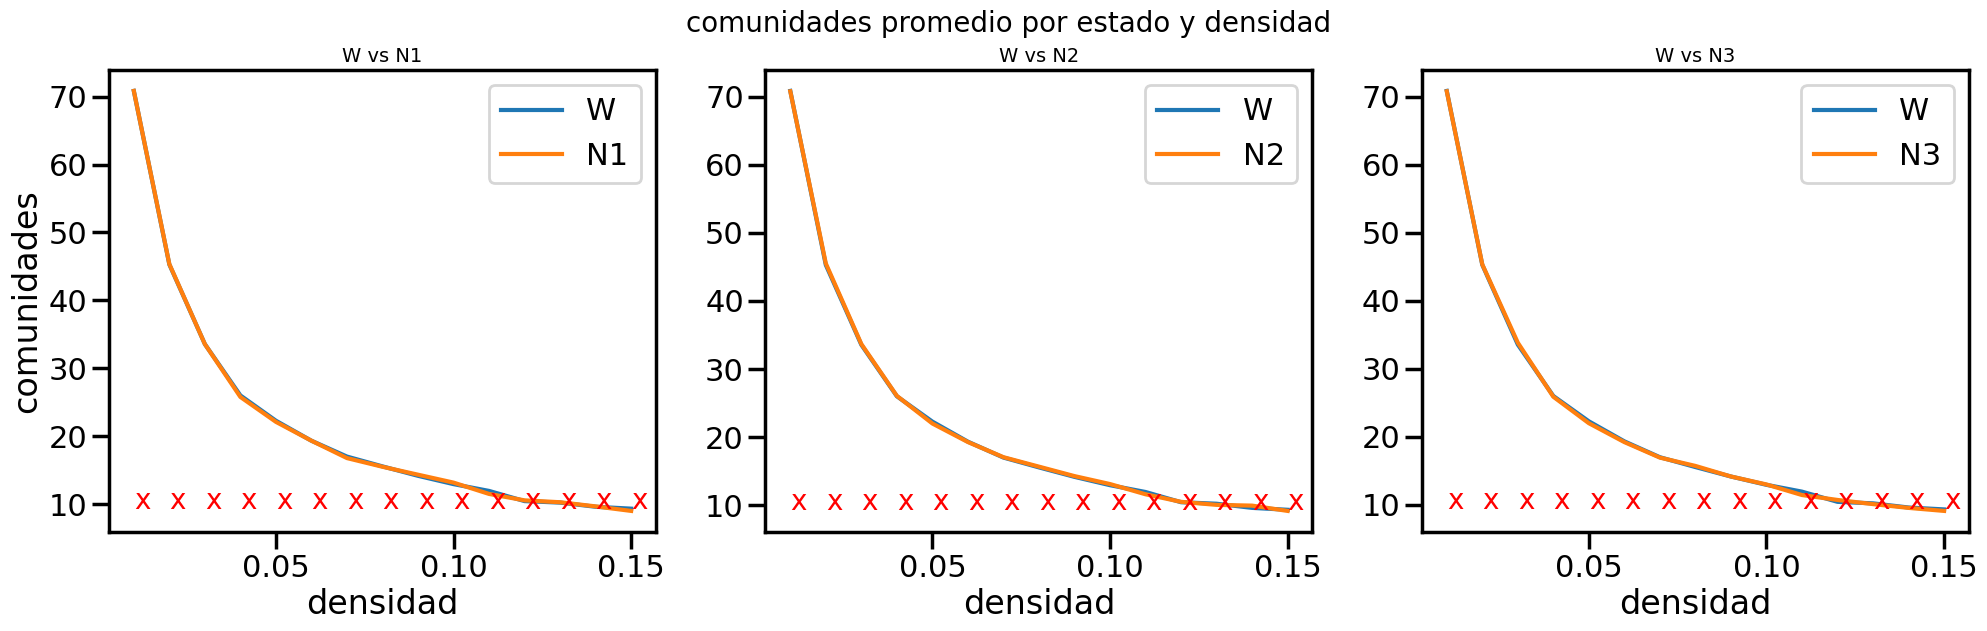

In [447]:
estado_vs_estado('comunidades')

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
layout = dict(zip(range(116),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

plt.suptitle('Grafos en estado N1 para densidades 0.01 y 0.02',size=15)
for n,densidad in enumerate([0.01,0.02]):
  G = grafo_densidad(matriz_promedio('N1'),densidad)
  nx.draw(G,layout, with_labels=True, linewidths =1,ax=ax[n])
  ax[n].set_title(f'Densidad {densidad}', fontsize=14)